In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 102870963.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50368271.86it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27569828.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8986098.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [4]:
# Training the model
start_time = time.time()
for epoch in range(5):  # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")
print('Finished Training')


[1,   200] loss: 0.460
[1,   400] loss: 0.110
[1,   600] loss: 0.085
[1,   800] loss: 0.072
[2,   200] loss: 0.047
[2,   400] loss: 0.052
[2,   600] loss: 0.045
[2,   800] loss: 0.045
[3,   200] loss: 0.026
[3,   400] loss: 0.033
[3,   600] loss: 0.031
[3,   800] loss: 0.038
[4,   200] loss: 0.021
[4,   400] loss: 0.024
[4,   600] loss: 0.026
[4,   800] loss: 0.026
[5,   200] loss: 0.014
[5,   400] loss: 0.017
[5,   600] loss: 0.019
[5,   800] loss: 0.020
Training Time: 75.77 seconds
Finished Training


In [6]:
import torch
from sklearn.metrics import f1_score, confusion_matrix

# Assuming 'device' is defined and your model is moved to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.2f}")

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy on test data: 99.01%
F1 Score: 0.99
Confusion Matrix:
[[ 978    0    0    0    0    0    0    1    1    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   1    0 1030    0    1    0    0    0    0    0]
 [   0    0    6 1002    0    1    0    0    1    0]
 [   0    0    1    0  970    0    2    0    1    8]
 [   2    0    1    9    0  876    4    0    0    0]
 [   4    2    2    0    1    1  947    0    1    0]
 [   0    7    9    0    0    0    0 1010    1    1]
 [   6    0    3    1    0    2    1    0  959    2]
 [   0    2    0    0    4    1    0    3    3  996]]


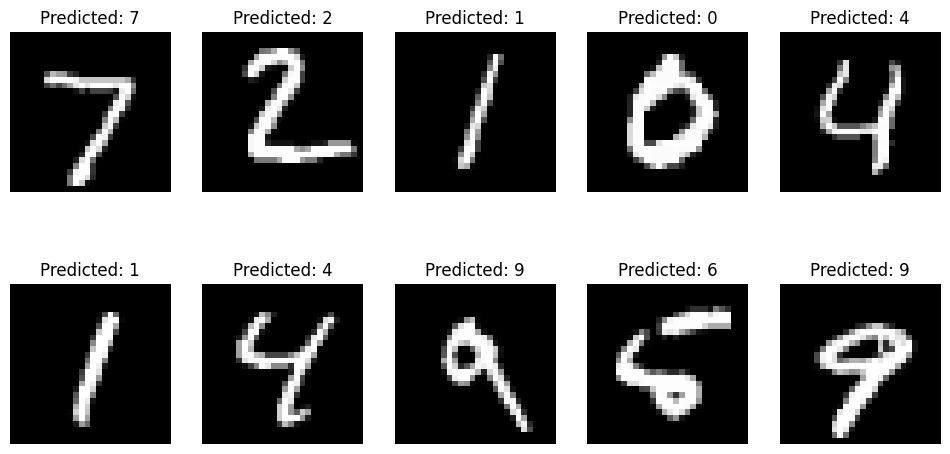

In [9]:
import torch
import matplotlib.pyplot as plt

# Get a batch of test data
images, labels = next(iter(testloader))

# Assuming 'device' is defined and your model is moved to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move images to the same device as the model
images = images.to(device)

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot images with predicted labels
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i][0].cpu(), cmap='gray')  # Move images to CPU for plotting
    plt.title(f"Predicted: {predicted[i].item()}")
    plt.axis('off')

plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the Region-based CNN (R-CNN) for image classification
class RCNN(nn.Module):
    def __init__(self):
        super(RCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)  # 10 classes for MNIST
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [11]:
# Initialize the model, loss function, and optimizer
model = RCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")
print('Finished Training')


[1,   100] loss: 0.715
[1,   200] loss: 0.182
[1,   300] loss: 0.131
[1,   400] loss: 0.098
[1,   500] loss: 0.083
[1,   600] loss: 0.083
[1,   700] loss: 0.077
[1,   800] loss: 0.068
[1,   900] loss: 0.065
[2,   100] loss: 0.057
[2,   200] loss: 0.045
[2,   300] loss: 0.041
[2,   400] loss: 0.046
[2,   500] loss: 0.052
[2,   600] loss: 0.045
[2,   700] loss: 0.042
[2,   800] loss: 0.045
[2,   900] loss: 0.046
[3,   100] loss: 0.036
[3,   200] loss: 0.028
[3,   300] loss: 0.034
[3,   400] loss: 0.035
[3,   500] loss: 0.033
[3,   600] loss: 0.031
[3,   700] loss: 0.032
[3,   800] loss: 0.031
[3,   900] loss: 0.029
[4,   100] loss: 0.023
[4,   200] loss: 0.024
[4,   300] loss: 0.017
[4,   400] loss: 0.018
[4,   500] loss: 0.029
[4,   600] loss: 0.023
[4,   700] loss: 0.029
[4,   800] loss: 0.025
[4,   900] loss: 0.024
[5,   100] loss: 0.014
[5,   200] loss: 0.020
[5,   300] loss: 0.016
[5,   400] loss: 0.018
[5,   500] loss: 0.015
[5,   600] loss: 0.022
[5,   700] loss: 0.022
[5,   800] 

In [13]:
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9909
F1 Score: 0.9907
Confusion Matrix:
[[ 978    0    1    0    0    0    0    1    0    0]
 [   0 1132    0    1    0    0    0    1    0    1]
 [   3    0 1024    0    0    0    0    5    0    0]
 [   0    0    1 1005    0    3    0    0    1    0]
 [   0    0    0    0  977    0    0    0    1    4]
 [   2    0    1    7    0  881    1    0    0    0]
 [   7    2    0    0    1    9  936    0    3    0]
 [   0    2    4    1    1    0    0 1019    0    1]
 [   3    0    2    2    1    2    0    0  960    4]
 [   0    0    1    0    5    2    0    4    0  997]]


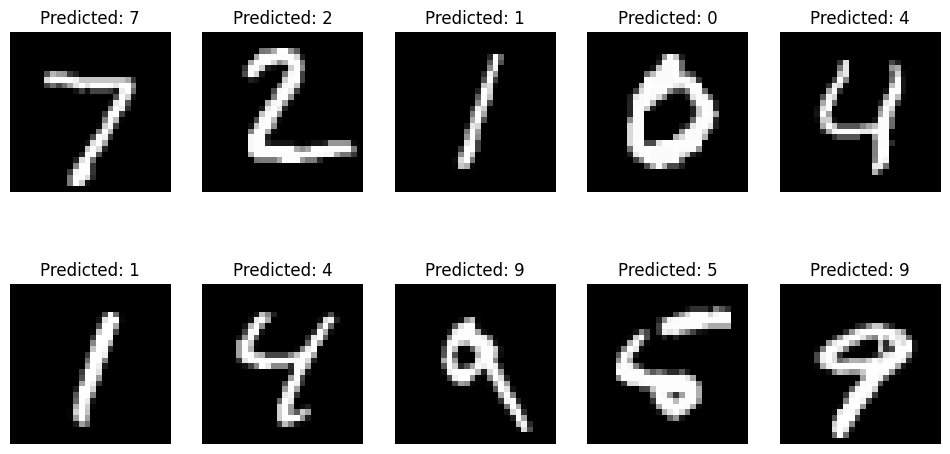

In [15]:
import matplotlib.pyplot as plt
import torch

# Get a batch of test data
images, labels = next(iter(testloader))

# Assuming 'device' is defined and your model is moved to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move data to GPU if available
images = images.to(device)

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot images with predicted labels
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i][0].cpu(), cmap='gray')  # Move images to CPU for plotting
    plt.title(f"Predicted: {predicted[i].item()}")
    plt.axis('off')

plt.show()


In [16]:
import torchvision.models as models
import torch.optim as optim
import time
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit VGG16 and AlexNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to pseudo-RGB
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load MNIST dataset
train_data = MNIST(root='./data', train=True, transform=transform, download=True)
test_data = MNIST(root='./data', train=False, transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100)

# Define function for fine-tuning
def fine_tune_model(model, train_loader, test_loader, num_epochs=1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Training the model
    start_time = time.time()

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch %d, Loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

    print('Finished Training')
    print('Training time:', time.time() - start_time)

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: %d %%' % accuracy)
    return accuracy

# Load VGG16 model
model_vgg16 = models.vgg16(pretrained=True)
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_features, 10)  # Change the last fully connected layer for 10 classes

# Load AlexNet model
model_alexnet = models.alexnet(pretrained=True)
model_alexnet.classifier[6] = nn.Linear(4096, 10)  # Change the last fully connected layer for 10 classes

# Fine-tune VGG16
print("\nFine-tuning VGG16...")
vgg16_accuracy = fine_tune_model(model_vgg16, train_loader, test_loader)

# Fine-tune AlexNet
print("\nFine-tuning AlexNet...")
alexnet_accuracy = fine_tune_model(model_alexnet, train_loader, test_loader)

# Compare accuracies
print("\nAccuracy comparison:")
print("VGG16 accuracy:", vgg16_accuracy)
print("AlexNet accuracy:", alexnet_accuracy)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 54.3MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future


Fine-tuning VGG16...
Epoch 1, Loss: 0.163
Finished Training
Training time: 966.966630935669
Accuracy of the network on the 10000 test images: 98 %

Fine-tuning AlexNet...
Epoch 1, Loss: 0.153
Finished Training
Training time: 140.9734344482422
Accuracy of the network on the 10000 test images: 98 %

Accuracy comparison:
VGG16 accuracy: 98.92
AlexNet accuracy: 98.79
